# Hierarchical bootsrap

### Set path

In [1]:
PROJECT_PATH = 'C:/Users/micha/projects/oscillation_vs_exponent/'

## Set-up

### Imports

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time

### Settings

In [3]:
N_ITERATIONS = 1000 # number of iterations for bootstrapping
VAR = 'exponent' # variable to analyze

## Main

### load specparam results

In [4]:
# load spectral parameterization results
results = pd.read_csv(f"{PROJECT_PATH}/data/results/spectral_parameters.csv", index_col=0)

# show
print(results.shape)
print(len(results)/8)
results.head()

(5560, 19)
695.0


,patient,chan_idx,label,pos_y,pos_x,pos_z,unique_id,material,memory,epoch,offset,knee,exponent,f_rotation,alpha_cf,alpha_pw,alpha_bw,alpha_bp,alpha_adj
0,pat02,0,A01-A02,-65.43100,61.94490,3.55955,pat02_0,words,hit,prestim,8.451107,12.903272,3.542673,10.978558,NaN,NaN,NaN,27777.899824,5664.172994
1,pat02,1,A02-A03,-70.93895,57.17765,12.15540,pat02_1,words,hit,prestim,7.595982,12.332651,3.052480,83.836257,10.839096,0.210785,2.000000,14445.161672,2948.320508
2,pat02,2,A03-A04,-75.39550,51.39440,20.94335,pat02_2,words,hit,prestim,7.056773,8.787521,2.774045,89.824561,12.850783,0.276397,2.000000,15085.969728,4269.780182
3,pat02,3,A04-A05,-78.91950,43.90980,30.13485,pat02_3,words,hit,prestim,7.595080,10.177476,2.940543,59.883041,NaN,NaN,NaN,23672.502537,2726.078761
4,pat02,4,A05-A06,-80.96735,35.21485,38.13475,pat02_4,words,hit,prestim,7.399935,9.126477,2.872949,65.871345,11.565201,0.227912,2.671217,21742.063343,3556.630628


In [5]:
# get results for task-modulated channels

# load task-modulated channel info
task_modulated_channels = pd.read_csv(f"{PROJECT_PATH}/data/results/ieeg_modulated_channels.csv", index_col=0)

# join info with results
df_merge = pd.merge(results, task_modulated_channels, on=['patient','chan_idx','material','memory'])

# get task-modulated channel results only
results = df_merge.loc[df_merge['sig']]
results

,patient,chan_idx,label,pos_y,pos_x,pos_z,unique_id,material,memory,epoch,...,f_rotation,alpha_cf,alpha_pw,alpha_bw,alpha_bp,alpha_adj,p_val,sign,sig_tm,sig
2,pat02,1,A02-A03,-70.93895,57.17765,12.15540,pat02_1,words,hit,prestim,...,83.836257,10.839096,0.210785,2.000000,14445.161672,2948.320508,0.0460,-1,True,True
3,pat02,1,A02-A03,-70.93895,57.17765,12.15540,pat02_1,words,hit,poststim,...,83.836257,NaN,NaN,NaN,17070.159190,1877.064258,0.0460,-1,True,True
8,pat02,4,A05-A06,-80.96735,35.21485,38.13475,pat02_4,words,hit,prestim,...,65.871345,11.565201,0.227912,2.671217,21742.063343,3556.630628,0.0000,1,True,True
9,pat02,4,A05-A06,-80.96735,35.21485,38.13475,pat02_4,words,hit,poststim,...,65.871345,NaN,NaN,NaN,13166.935700,-647.224520,0.0000,1,True,True
18,pat04,0,A01-A09,-58.30120,52.43075,-26.23685,pat04_0,words,hit,prestim,...,36.927875,9.468345,0.655227,2.200840,147381.091963,92616.547726,0.0012,1,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5317,pat22,25,PI_05-PI_06,-10.50000,-40.00000,32.50000,pat22_25,faces,miss,poststim,...,NaN,7.303599,0.441313,2.000000,2353.031222,218.392527,0.0286,-1,True,True
5324,pat22,29,PI_09-PI_10,-11.50000,-41.00000,60.50000,pat22_29,faces,miss,prestim,...,55.890838,NaN,NaN,NaN,20708.678733,1308.590509,0.3236,-1,False,True
5325,pat22,29,PI_09-PI_10,-11.50000,-41.00000,60.50000,pat22_29,faces,miss,poststim,...,55.890838,NaN,NaN,NaN,24299.172337,-7349.650002,0.3236,-1,False,True
5368,pat22,51,MOF_08-MOF_09,48.00000,-14.00000,23.50000,pat22_51,faces,miss,prestim,...,43.914230,NaN,NaN,NaN,3829.861430,-176.791341,0.0006,-1,True,True


In [6]:
# split results by trial type (words/faces) and take successful trials only (memory==hit)
df_w = results.loc[((results['memory']=='hit')&(results['material']=='words'))]
df_f = results.loc[((results['memory']=='hit')&(results['material']=='faces'))]

# start with one trial type
df = df_w.copy()


### perform hierarchical bootsrap
level 1: epoch (experimental condition)  
level 2: patient  
level 3: channel

In [7]:
# # count number of channels for each patient
# patients = results['patient'].unique()
# temp = results[(results['memory']=='hit') & (results['material']=='words') & (results['epoch']=='prestim')]
# n_channels = dict()
# for patient in patients:
#     n_channels[patient] = len(temp.loc[temp['patient']==patient])
# n_channels

In [8]:
# # perform hierarchical bootstrap on exponent values

# # time it 
# t_start = time()

# # successful trials only
# df = results[results['memory']=='hit']
# n_samples = len(df)

# # get levels
# epochs = df['epoch'].unique()
# materials = df['material'].unique()
# # patients = df['patient'].unique()

# # loop through iterations
# diff = np.zeros(N_ITERATIONS)
# for i_iteration in range(N_ITERATIONS):
#     # display progress
#     print(f"Iteration {i_iteration+1}/{N_ITERATIONS}")

#     # resample level 1: epoch
#     epochs = np.random.choice(epochs, size=n_samples)
#     # resample level 2: patient
#     patients = np.random.choice(patients, size=n_samples)

#     # resample level 3: channel, and get data
#     value = np.zeros(n_samples)
#     for i_sample, (epoch, patient) in enumerate(zip(epochs, patients)):
#         # resample level 4: channel
#         channel = np.random.choice(n_channels[patient], size=1)[0]

#         # get data
#         value[i_sample] = df.loc[(df['epoch']==epoch) & (df['patient']==patient) & (df['chan_idx']==channel), VAR].values[0]

#     # compute difference between resampled experimental conditions
#     diff[i_iteration] = np.nanmean(value[len(value)//2:]) - np.nanmean(value[:len(value)//2])
#     # print(diff[i_iteration])

# # compute true difference between experimental conditions 
# true_diff = np.nanmean(df.loc[df['epoch']=='poststim', VAR]) - \
#     np.nanmean(df.loc[df['epoch']=='prestim', VAR])
# print(f"True difference: {true_diff :0.3f}")

# # plot
# fig, ax = plt.subplots(figsize=(6,4))
# ax.hist(diff, bins=20, color='k')
# ax.axvline(true_diff, color='k', linestyle='--')
# ax.set_xlabel('exponent difference')
# ax.set_ylabel('count')
# ax.set_title('Resampled exponent')
# plt.show()

# # print time
# print(f"Resampling completed in {time() - t_start :0.1f} s")

In [9]:
# diff_w = diff.copy()
# true_diff_w = true_diff.copy()

In [10]:
# # perform hierarchical bootstrap on exponent values

# # now the other trial type
# df = df_f.copy()

# # time it 
# t_start = time()

# # successful trials only
# df = results[results['memory']=='hit']
# n_samples = len(df)

# # get levels
# epochs = df['epoch'].unique()
# materials = df['material'].unique()
# # patients = df['patient'].unique()

# # loop through iterations
# diff = np.zeros(N_ITERATIONS)
# for i_iteration in range(N_ITERATIONS):
#     # display progress
#     print(f"Iteration {i_iteration+1}/{N_ITERATIONS}")

#     # resample level 1: epoch
#     epochs = np.random.choice(epochs, size=n_samples)
#     # resample level 2: patient
#     patients = np.random.choice(patients, size=n_samples)

#     # resample level 3: channel, and get data
#     value = np.zeros(n_samples)
#     for i_sample, (epoch, patient) in enumerate(zip(epochs, patients)):
#         # resample level 4: channel
#         channel = np.random.choice(n_channels[patient], size=1)[0]

#         # get data
#         value[i_sample] = df.loc[(df['epoch']==epoch) & (df['patient']==patient) & (df['chan_idx']==channel), VAR].values[0]

#     # compute difference between resampled experimental conditions
#     diff[i_iteration] = np.nanmean(value[len(value)//2:]) - np.nanmean(value[:len(value)//2])
#     # print(diff[i_iteration])

# # compute true difference between experimental conditions 
# true_diff = np.nanmean(df.loc[df['epoch']=='poststim', VAR]) - \
#     np.nanmean(df.loc[df['epoch']=='prestim', VAR])
# print(f"True difference: {true_diff :0.3f}")

# # plot
# fig, ax = plt.subplots(figsize=(6,4))
# ax.hist(diff, bins=20, color='k')
# ax.axvline(true_diff, color='k', linestyle='--')
# ax.set_xlabel('\u0394 exponent')
# ax.set_ylabel('count')
# plt.show()

# # print time
# print(f"Resampling completed in {time() - t_start :0.1f} s")

In [11]:
# diff_f = diff.copy()
# true_diff_f = true_diff.copy()

### save/load results

In [12]:
# # save results
# # np.savez(f"{PROJECT_PATH}/data/results/hierarchical_bootstrap", diff_f=diff_f, diff_w=diff_w, true_diff_f=true_diff_f, true_diff_w=true_diff_w)

# # load results
# fname_in = f"{PROJECT_PATH}/data/results/hierarchical_bootstrap.npz"
# data_in = np.load(fname_in)
# diff_f = data_in['diff_f']
# diff_w = data_in['diff_w']
# true_diff_f = data_in['true_diff_f']
# true_diff_w = data_in['true_diff_w']


### plot results

In [13]:
# # plot results for both trial types

# # plot
# fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

# ax1.hist(diff_w, bins=20, color='k')
# ax1.axvline(true_diff_w, color='k', linestyle='--')
# ax1.set_title('word-encoding')

# ax2.hist(diff_f, bins=20, color='k')
# ax2.axvline(true_diff_f, color='k', linestyle='--')
# ax2.set_title('face-encoding')

# for ax in [ax1, ax2]:
#     ax.set_xlabel('\u0394 exponent')
#     ax.set_ylabel('count')
# plt.show()

# print(f"word-encoding: {true_diff_w}")
# print(f"face-encoding: {true_diff_f}")


### include material as additional level

In [14]:
# # perform hierarchical bootstrap - include material as additional level

# # time it 
# t_start = time()

# # successful trials only
# df = results[results['memory']=='hit']
# n_samples = len(df)

# # get levels
# epochs = df['epoch'].unique()
# materials = df['material'].unique()

# # loop through iterations
# diff = np.zeros(n_iterations)
# for ii in range(n_iterations):
#     # display progress
#     print(f"Iteration {ii+1}/{n_iterations}")

#     # resample level 1: epoch
#     epochs = np.random.choice(epochs, size=n_samples)
#     # resample level 2: material
#     materials = np.random.choice(materials, size=n_samples)
#     # resample level 3: patient
#     patients = np.random.choice(patients, size=n_samples)

#     # resample level 4: channel, and get data
#     value = np.zeros(n_samples)
#     for i_sample, (epoch, material, patient) in enumerate(zip(epochs, materials, patients)):
#         # resample level 4: channel
#         channel = np.random.choice(n_channels[patient], size=1)[0]

#         # get data
#         value[i_sample] = df.loc[(df['epoch']==epoch) & (df['material']==material) \
#             & (df['patient']==patient) & (df['chan_idx']==channel), var].values[0]

#     # compute difference between resampled experimental conditions
#     diff[i_iteration] = np.nanmean(value[len(value)//2:]) - np.nanmean(value[:len(value)//2])
#     print(diff[i_iteration])

# # plot
# fig, ax = plt.subplots(figsize=(6,4))
# ax.hist(diff, bins=20, color='k')
# ax.axvline(true_diff, color='k', linestyle='--')
# ax.set_xlabel('exponent difference')
# ax.set_ylabel('count')
# ax.set_title('Resampled exponent')
# plt.show()

# # print time
# print(f"Resampling completed in {time() - t_start :0.1f} s")

### develop generalized hierarchical bootstrap function

In [15]:
def plot_permutation_results(distribution, true_diff):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.hist(distribution, bins=20, color='k', label='resampled difference')
    ax.axvline(true_diff, color='k', linestyle='--', label='true difference')
    ax.set_xlabel('difference')
    ax.set_ylabel('count')
    ax.set_title('Permutation test results')
    ax.legend()
    plt.show()

In [16]:
# # hierarchical bootstrap function

# def hierarchical_bootstrap(df, variable, condition, level_2, level_3, iterations, verbose=True):
#     """
#     Perform hierarchical bootstrap on data. This function assumes that each cluster is 
#     represented in each experimental condition.
    
#     Parameters
#     ----------
#     df : pandas.DataFrame
#         Dataframe containing data to resample.
#     variable : str
#         Variable to resample.
#     condition : str
#         Experimental condition of interest (level 1 of hierarchy).
#     level_2 : str
#         Level 2 of hierarchy.
#     level_3 : str
#         Level 3 of hierarchy.
#     iterations : int
#         Number of iterations for resampling.
#     verbose : bool
#         If True, print results.

#     Returns
#     -------
#     distribution : numpy.ndarray
#         Resampled distribution of differences between experimental conditions.
#     true_diff : float
#         True difference between experimental conditions.

#     """
#     # check that there are only two experimental conditions
#     conditions = df[condition].unique()
#     if len(conditions) != 2:
#         raise ValueError("More than two experimental conditions detected.")

#     # check that each cluster is represented in each experimental condition
#     clusters = df.loc[df[condition]==conditions[0], level_2].unique()
#     clusters_1 = df.loc[df[condition]==conditions[1], level_2].unique()
#     if not np.array_equal(clusters, clusters_1):
#         raise ValueError("Each cluster must be represented in each experimental condition.")
#     n_clusters = len(clusters) * 2 # number of clusters across both experimental conditions
    
#     # compute true difference between experimental conditions 
#     true_diff = np.nanmean(df.loc[df[condition]==conditions[1], variable]) - \
#         np.nanmean(df.loc[df[condition]==conditions[0], variable])

#     # loop through iterations
#     distribution = np.zeros(iterations)
#     for i_iteration in range(iterations):
#         # display progress
#         print(f"Iteration {i_iteration+1}/{iterations}")

#         # Resample level 2 
#         # Because each cluster is represented in both experimental conditions,
#         # we must resample cluster-condition pairs for each surrogate group.
#         clusters_resampled = np.vstack([np.random.choice([0, 1], size=len(clusters)*2), \
#             np.random.choice(clusters, size=len(clusters)*2)]).T

#         # resample level 3
#         values = np.zeros(n_clusters)
#         for i_cluster, cluster_i in enumerate(clusters_resampled):
#             # resample level 3
#             instances = instances = df.loc[(df[condition]==conditions[cluster_i[0]]) & (df[level_2]==cluster_i[1]), level_3].unique()
#             instances_resampled = np.random.choice(instances, size=len(instances))

#             # get data
#             values_cluster = np.zeros(len(instances))
#             for i_instance, instance_i in enumerate(instances_resampled):
#                 values_cluster[i_instance] = df.loc[(df[condition]==conditions[cluster_i[0]]) & (df[level_2]==cluster_i[1]) \
#                     & (df[level_3]==instance_i), variable].values[0]
#             values[i_cluster] = np.nanmean(values_cluster)

#         # compute difference between surrogate groups
#         distribution[i_iteration] = np.nanmean(values[len(values)//2:]) - np.nanmean(values[:len(values)//2])

#     # compute p-value (proportion of surrogate differences greater than true difference)
#     p_value = np.sum(np.abs(distribution) > np.abs(true_diff)) / len(distribution)

#     # print results
#     if verbose:
#         print(f"True difference: {true_diff :0.3f}")
#         print(f"p-value: {p_value :0.3f}")

#     return p_value, distribution, true_diff


In [17]:
# hierarchical bootstrap function

def hierarchical_bootstrap(df, variable, condition, level_2, level_3, iterations, verbose=True):
    """
    Perform hierarchical bootstrap on data. 
    
    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe containing data to resample.
    variable : str
        Variable to resample.
    condition : str
        Experimental condition of interest (level 1 of hierarchy).
    level_2 : str
        Level 2 of hierarchy.
    level_3 : str
        Level 3 of hierarchy.
    iterations : int
        Number of iterations for resampling.
    verbose : bool
        If True, print results.

    Returns
    -------
    distribution : numpy.ndarray
        Resampled distribution of differences between experimental conditions.
    true_diff : float
        True difference between experimental conditions.

    """
    # check that there are only two experimental conditions
    conditions = df[condition].unique()
    if len(conditions) != 2:
        raise ValueError("More than two experimental conditions detected.")

    # get cluster info
    clusters = df[level_2].unique()
    n_clusters = len(clusters)
    
    # compute true difference between experimental conditions 
    true_diff = np.nanmean(df.loc[df[condition]==conditions[1], variable]) - \
        np.nanmean(df.loc[df[condition]==conditions[0], variable])

    # loop through iterations
    distribution = np.zeros(iterations)
    for i_iteration in range(iterations):
        # display progress
        # print(f"Iteration {i_iteration+1}/{iterations}")

        # Resample level 2 
        clusters_resampled = np.random.choice(clusters, size=n_clusters)

        # resample level 3 and get data for each cluster
        values = np.zeros(n_clusters)
        for i_cluster, cluster_i in enumerate(clusters_resampled):
            # resample level 3
            instances = df.loc[df[level_2]==cluster_i, level_3].unique()
            instances_resampled = np.random.choice(instances, size=len(instances))

            # get data for each instance within cluster and average
            values_cluster = np.zeros(len(instances))
            for i_instance, instance_i in enumerate(instances_resampled):
                values_cluster[i_instance] = df.loc[(df[level_2]==cluster_i) \
                    & (df[level_3]==instance_i), variable].values[0]
            values[i_cluster] = np.nanmean(values_cluster)

        # compute difference between surrogate groups
        distribution[i_iteration] = np.nanmean(values[len(values)//2:]) - np.nanmean(values[:len(values)//2])

    # compute p-value (proportion of surrogate differences greater than true difference)
    p_value = np.sum(np.abs(distribution) > np.abs(true_diff)) / len(distribution)

    # print results
    if verbose:
        print(f"True difference: {true_diff :0.3f}")
        print(f"p-value: {p_value :0.3f}")

    return p_value, distribution, true_diff


#############################################
word-encoding
#############################################

Variable: exponent
True difference: -0.176
p-value: 0.220


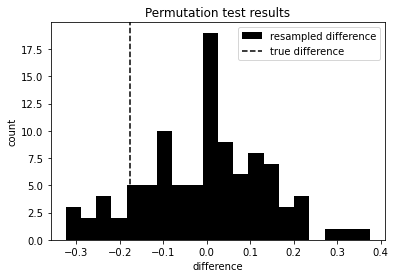


Variable: alpha_pw


C:\Users\micha\AppData\Local\Temp\ipykernel_39164\2506369123.py:66: RuntimeWarning: Mean of empty slice
  values[i_cluster] = np.nanmean(values_cluster)


True difference: -0.052
p-value: 0.540


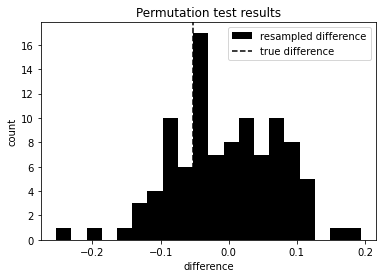


Variable: alpha_bp
True difference: -4788.481
p-value: 0.620


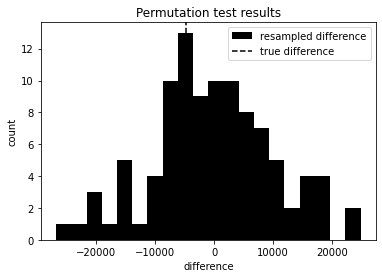


Variable: alpha_adj
True difference: -2961.657
p-value: 0.670


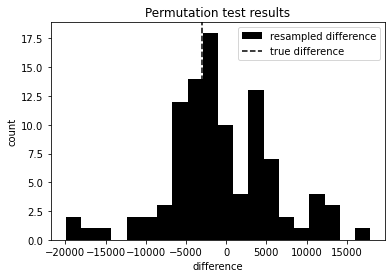

#############################################
face-encoding
#############################################

Variable: exponent
True difference: -0.171
p-value: 0.240


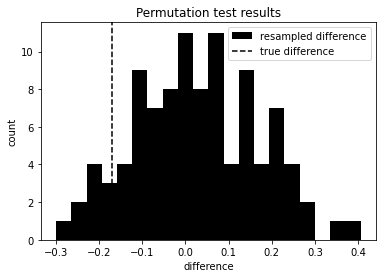


Variable: alpha_pw
True difference: 0.028
p-value: 0.770


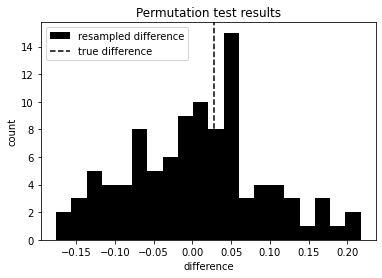


Variable: alpha_bp
True difference: -1643.991
p-value: 0.890


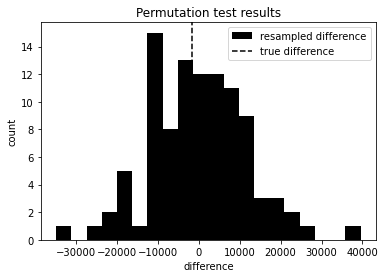


Variable: alpha_adj
True difference: -323.450
p-value: 0.950


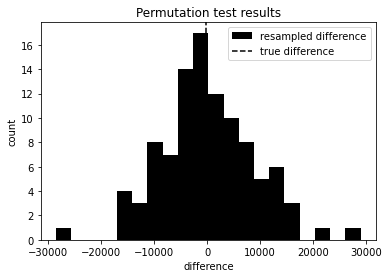

In [18]:
# apply hierarchical bootstrap to exponent values
for df, material in zip([df_w, df_f],['word-encoding','face-encoding']):
    # display progress
    print("#############################################")
    print(material)
    print("#############################################")

    for variable in ['exponent','alpha_pw','alpha_bp','alpha_adj']:
        # display progress
        print(f"\nVariable: {variable}")

        # create unique_id column
        df_r = df.copy()
        df_r['unique_id'] = df_r['patient'] + '_' + df_r['epoch']

        # apply hierarchical bootstrap
        p_value, distribution, true_diff = hierarchical_bootstrap(df_r, variable, 'epoch', 'unique_id', 'chan_idx', 100)
        plot_permutation_results(distribution, true_diff)

True difference: 0.167
p-value: 0.510


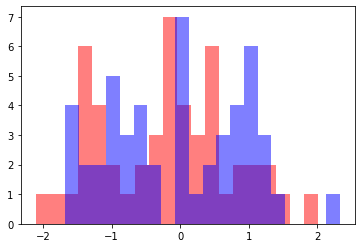

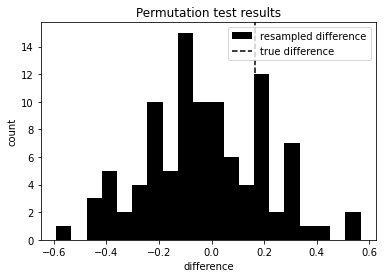

True difference: 0.931
p-value: 0.000


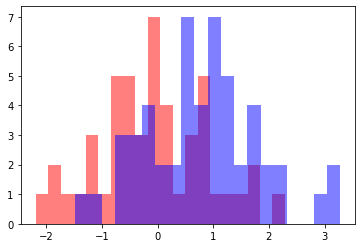

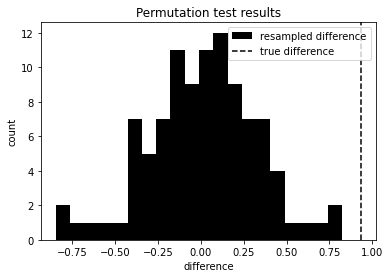

True difference: 1.088
p-value: 0.000


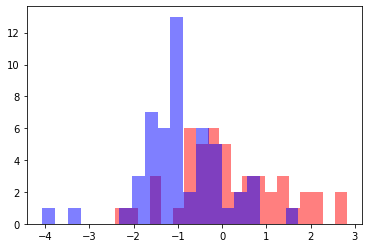

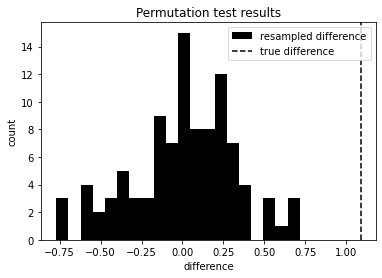

True difference: 2.022
p-value: 0.000


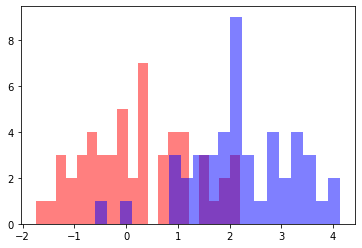

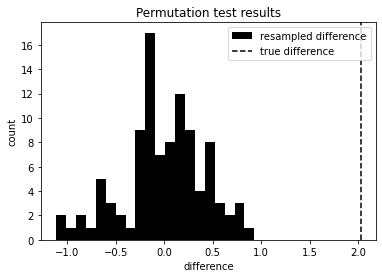

In [58]:
# test hierarchical bootstrap function on simulted data

# create simulated data
n_clusters = 10
n_instances = 10

# 
for shift in [0, 1, -1, 2]:
    # create dataframe
    df = pd.DataFrame(columns=['condition','cluster','instance','value'])
    for i_cluster in range(n_clusters):
        for i_instance in range(n_instances):
            df_i = pd.DataFrame(columns=['condition','cluster','instance','value'])
            df_i['condition'] = np.random.choice([0,1], size=1)
            df_i['cluster'] = i_cluster
            df_i['instance'] = i_instance
            df_i['value'] = np.random.randn()
            df = pd.concat([df, df_i], ignore_index=True)

    # shift values for condition 1
    df.loc[df['condition']==1, 'value'] += shift

    # convert value column to float
    df['value'] = df['value'].astype(float)

    # plot
    fig, ax = plt.subplots(figsize=(6,4))
    ax.hist(df.loc[df['condition']==0, 'value'], bins=20, color='r', alpha=0.5)
    ax.hist(df.loc[df['condition']==1, 'value'], bins=20, color='b', alpha=0.5)

    # apply hierarchical bootstrap
    p_value, distribution, true_diff = hierarchical_bootstrap(df, 'value', 'condition', 'cluster', 'instance', 100)
    plot_permutation_results(distribution, true_diff)